In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import sys
sys.path.append('../../CppToPython')

In [3]:
import GeDiM4Py as gedim

In [4]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [5]:
# ------------------------ Definizione della rete neurale ------------------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Rete fully connected con 2 hidden layers e funzione di attivazione Tanh
        self.net = nn.Sequential(
            nn.Linear(4, 64),    # input: x0, x1, mu0, mu1
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)     # output: u(x, mu)
        )

    def forward(self, xmu):
        # Forward pass: calcola u dato input (x0,x1,mu0,mu1)
        return self.net(xmu)

In [6]:
# ------------------------ Calcolo del residuo PDE ------------------------
def pde_residual(xmu, net):
    """
    Calcola il residuo della PDE in ogni punto (interno al dominio)
    -xmu: tensor Nx4 con (x0, x1, mu0, mu1)
    -net: la rete neurale che approssima u
    """
    xmu.requires_grad_(True)      # necessario per calcolare derivate rispetto a xmu
    u = net(xmu)                 # output della rete: u(x,mu)

    # Calcolo gradiente di u rispetto a input (x0, x1) per le derivate prime
    grads = torch.autograd.grad(u.sum(), xmu, create_graph=True)[0]
    u_x0 = grads[:, 0:1]          # ∂u/∂x0
    u_x1 = grads[:, 1:2]          # ∂u/∂x1

    # Calcolo derivate seconde per laplaciano
    u_x0x0 = torch.autograd.grad(u_x0.sum(), xmu, create_graph=True)[0][:, 0:1]  # ∂²u/∂x0²
    u_x1x1 = torch.autograd.grad(u_x1.sum(), xmu, create_graph=True)[0][:, 1:2]  # ∂²u/∂x1²
    laplacian_u = u_x0x0 + u_x1x1  # ∆u

    # Estrazione parametri mu0 e mu1
    mu0 = xmu[:, 2:3]
    mu1 = xmu[:, 3:4]

    # Coordinate spaziali
    x0 = xmu[:, 0:1]
    x1 = xmu[:, 1:2]

    # Termine sorgente g(x;mu)
    g = 100 * torch.sin(2 * np.pi * x0) * torch.cos(2 * np.pi * x1)

    # Termine non lineare con mu0, mu1
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Residuo PDE: -∆u + nonlinear - g = 0
    residual = -laplacian_u + nonlinear - g
    return residual

In [7]:
# ------------------------ Generazione punti dominio e bordo ------------------------
def generate_domain_points(N_interior, N_boundary, mu0_range, mu1_range):
    """
    Genera punti interni e di bordo del dominio con campionamento uniforme
    anche dei parametri mu0, mu1 negli intervalli specificati
    """
    mu0_min, mu0_max = mu0_range
    mu1_min, mu1_max = mu1_range

    # --- Punti interni ---
    x0 = torch.rand(N_interior, 1)  # coordinate x0 in (0,1)
    x1 = torch.rand(N_interior, 1)  # coordinate x1 in (0,1)
    mu0 = mu0_min + (mu0_max - mu0_min) * torch.rand(N_interior, 1)  # parametri mu0 casuali nell’intervallo
    mu1 = mu1_min + (mu1_max - mu1_min) * torch.rand(N_interior, 1)  # parametri mu1 casuali nell’intervallo
    xmu_interior = torch.cat([x0, x1, mu0, mu1], dim=1)

    # --- Punti sul bordo ---
    xb = []
    for side in range(4):
        s = torch.rand(N_boundary, 1)          # coordinata variabile sul lato
        zeros = torch.zeros_like(s)             # vettore di zeri
        ones = torch.ones_like(s)               # vettore di uni

        if side == 0:
            # lato inferiore y=0
            x0b, x1b = s, zeros
        elif side == 1:
            # lato superiore y=1
            x0b, x1b = s, ones
        elif side == 2:
            # lato sinistro x=0
            x0b, x1b = zeros, s
        else:
            # lato destro x=1
            x0b, x1b = ones, s

        mu0b = mu0_min + (mu0_max - mu0_min) * torch.rand(N_boundary, 1)  # mu0 bordo
        mu1b = mu1_min + (mu1_max - mu1_min) * torch.rand(N_boundary, 1)  # mu1 bordo

        xb.append(torch.cat([x0b, x1b, mu0b, mu1b], dim=1))

    xmu_boundary = torch.cat(xb, dim=0)
    n_boundary_points = len(xmu_boundary)



    return xmu_interior, xmu_boundary

In [8]:
# ------------------------ Funzione di training ------------------------
def train_pinn(net, epochs=5000, N_interior=1000, N_boundary=200, lr=1e-3,
               mu0_range=(0.1, 1.0), mu1_range=(0.1, 1.0)):
    """
    Addestra la rete PINN minimizzando residuo PDE e rispettando condizioni di Dirichlet
    """
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):

        optimizer.zero_grad()
        net.train()
        # Genera punti (interni e bordo) con mu0, mu1 random su intervalli
        xmu_int, xmu_bnd = generate_domain_points(N_interior, N_boundary, mu0_range, mu1_range)

        # Calcola residuo PDE sui punti interni
        res_int = pde_residual(xmu_int, net)
        loss_pde = torch.mean(res_int ** 2)

        # Valuta la rete sui punti di bordo (condizione Dirichlet u=0)
        u_bnd = net(xmu_bnd)
        # qua residuo è u_bnd - 0
        loss_bc = torch.mean(u_bnd ** 2)

        # Loss totale: somma tra PDE residual e condizione al contorno (dovrei aggiungere un lambda)
        loss =  loss_pde +  loss_bc

        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 or epoch == 1:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f} (PDE = {loss_pde.item():.6f}, BC = {loss_bc.item():.6f})")

In [9]:
net = Net()
train_pinn(net,
           epochs=10000,
           N_interior=1000,
           N_boundary=200,
           lr=1e-3,
           mu0_range=(0.1, 1.0),
           mu1_range=(0.1, 1.0))

Epoch 1: Loss = 2342.560547 (PDE = 2342.549805, BC = 0.010656)
Epoch 500: Loss = 21.831886 (PDE = 12.112502, BC = 9.719385)
Epoch 1000: Loss = 6.969533 (PDE = 3.711552, BC = 3.257981)
Epoch 1500: Loss = 3.410815 (PDE = 1.346665, BC = 2.064150)
Epoch 2000: Loss = 2.526982 (PDE = 0.899493, BC = 1.627489)
Epoch 2500: Loss = 2.136566 (PDE = 0.677852, BC = 1.458714)
Epoch 3000: Loss = 1.612074 (PDE = 0.414998, BC = 1.197077)
Epoch 3500: Loss = 1.455597 (PDE = 0.360286, BC = 1.095311)
Epoch 4000: Loss = 1.280395 (PDE = 0.348173, BC = 0.932223)
Epoch 4500: Loss = 1.003274 (PDE = 0.256642, BC = 0.746632)
Epoch 5000: Loss = 0.718919 (PDE = 0.152333, BC = 0.566586)
Epoch 5500: Loss = 0.534858 (PDE = 0.124645, BC = 0.410214)
Epoch 6000: Loss = 0.437022 (PDE = 0.121740, BC = 0.315282)
Epoch 6500: Loss = 0.416075 (PDE = 0.138731, BC = 0.277344)
Epoch 7000: Loss = 0.332838 (PDE = 0.096185, BC = 0.236653)
Epoch 7500: Loss = 0.304319 (PDE = 0.098590, BC = 0.205729)
Epoch 8000: Loss = 0.265137 (PDE = 0

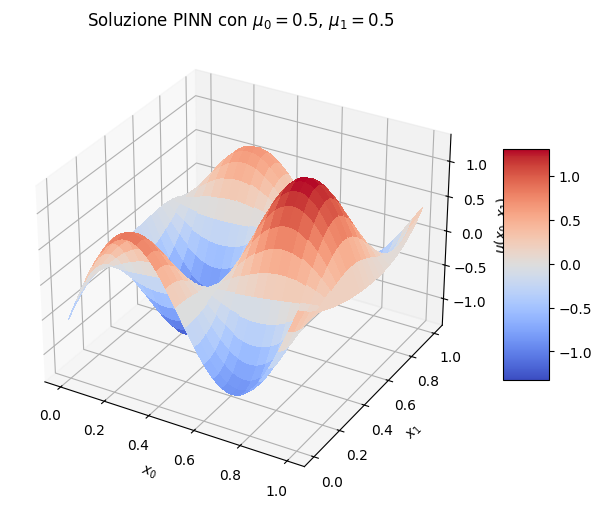

In [10]:
# Fissa parametri mu0 e mu1
mu0_val = 0.5
mu1_val = 0.5

# Griglia su (x0, x1)
x0 = np.arange(0, 1.01, 0.02)
x1 = np.arange(0, 1.01, 0.02)
X0, X1 = np.meshgrid(x0, x1)

# Prepara input per la rete: (x0, x1, mu0, mu1)
x0_flat = X0.flatten()[:, None]
x1_flat = X1.flatten()[:, None]
mu0_flat = mu0_val * np.ones_like(x0_flat)
mu1_flat = mu1_val * np.ones_like(x0_flat)

inputs = np.hstack([x0_flat, x1_flat, mu0_flat, mu1_flat])
inputs_torch = torch.from_numpy(inputs).float()

# Predizione rete (assumendo 'net' già addestrata e in eval mode)
net.eval()
with torch.no_grad():
    u_pred = net(inputs_torch).cpu().numpy()

# Ricostruisci la matrice della soluzione
U = u_pred.reshape(X0.shape)

# Plot 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X0, X1, U, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$u(x_0,x_1)$')
ax.set_title(f'Soluzione PINN con $\\mu_0={mu0_val}$, $\\mu_1={mu1_val}$')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

High fidelity

In [11]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
    #print("vecu max:", np.max(vecu))
    #print("mu_1 * vecu max:", np.max(mu_1 * vecu))
    return values_nl_b.ctypes.data

# f_4 (parte con la g)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


In [12]:
meshSize = 0.001
order = 1

In [13]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

In [14]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

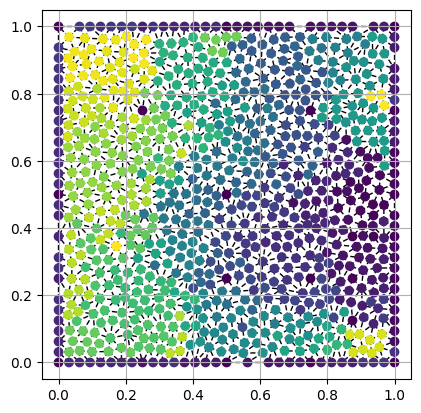

In [15]:
gedim.PlotDofs(mesh, dofs, strongs)

In [16]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [17]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [18]:
np.random.seed(42)  # Imposta il seed per la riproducibilità
snapshots_num = 100 # (M)
training_set = np.random.uniform(low=0.1, high=1, size=(snapshots_num, 2)) # training set

In [19]:
# Choose new random seed bc we need a new test set
np.random.seed(23)

test_set = np.random.uniform(low=0.1, high=1, size=(100, 2)) # test set

In [20]:
import time

print("{:<8s} {:<6s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

sol_hf = []
times_hf = []
times_pinn = []
speed_up = []

for mu in test_set:
    # risolvo il PINN
    # Fissa parametri mu0 e mu1
    mu0_val = mu[0]
    mu1_val = mu[1]
    
    # Griglia su (x0, x1)
    x0 = np.arange(0, 1.0, 0.02)
    x1 = np.arange(0, 1.0, 0.02)
    X0, X1 = np.meshgrid(x0, x1)
    
    # Prepara input per la rete: (x0, x1, mu0, mu1)
    x0_flat = X0.flatten()[:, None]
    x1_flat = X1.flatten()[:, None]
    mu0_flat = mu0_val * np.ones_like(x0_flat)
    mu1_flat = mu1_val * np.ones_like(x0_flat)
    
    inputs = np.hstack([x0_flat, x1_flat, mu0_flat, mu1_flat])
    inputs_torch = torch.from_numpy(inputs).float()
    
    time_start = time.time()
    # Predizione rete (assumendo 'net' già addestrata e in eval mode)
    net.eval()
    with torch.no_grad():
        u_pred = net(inputs_torch).cpu().numpy()
    time_pinn = time.time() - time_start
    times_pinn.append(time_pinn)

    # risolvo high fidelity
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_normL2 = 1
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0

    time_hf = 0
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction

        time_start = time.time()
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        time_hf += time.time() - time_start
        #update u_k
        u_k = u_k + du
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    sol_hf.append(np.copy(u_k))
    times_hf.append(time_hf)
    speed_up.append(time_hf/time_pinn)

DOFs     h       Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    1.000000e+00   1      100      mu = (0.566, 0.952)
713      0.064    9.453471e-03   2      100      mu = (0.566, 0.952)
713      0.064    1.422986e-06   3      100      mu = (0.566, 0.952)
713      0.064    3.728275e-14   4      100      mu = (0.566, 0.952)
713      0.064    1.000000e+00   1      100      mu = (0.789, 0.354)
713      0.064    4.503949e-03   2      100      mu = (0.789, 0.354)
713      0.064    1.086983e-07   3      100      mu = (0.789, 0.354)
713      0.064    9.163036e-17   4      100      mu = (0.789, 0.354)
713      0.064    1.000000e+00   1      100      mu = (0.299, 0.718)
713      0.064    3.710673e-03   2      100      mu = (0.299, 0.718)
713      0.064    7.370379e-08   3      100      mu = (0.299, 0.718)
713      0.064    7.913749e-17   4      100      mu = (0.299, 0.718)
713      0.064    1.000000e+00   1      100      mu = (0.250, 0.453)
713      0.064    1.911868e-03   2

In [21]:
print("Average speed-up = ", np.mean(speed_up))

Average speed-up =  1.168782641555226


In [22]:
print(type(u_k))

<class 'numpy.ndarray'>


In [23]:
print(type(u_pred))

<class 'numpy.ndarray'>


In [24]:
print(shape(u_k))

NameError: name 'shape' is not defined